In [ ]:
%run ./dataengine.ipynb

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Аугментация данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Приводим к размеру MobileNetV2
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к папкам
train_dir = "data/split_ttv_dataset_type_of_plants/Train_Set_Folder"
val_dir = "data/split_ttv_dataset_type_of_plants/Validation_Set_Folder"
test_dir = "data/split_ttv_dataset_type_of_plants/Test_Set_Folder"

# Загружаем данные
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Проверим классы
print("Классы:", train_data.classes)


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Загружаем предобученную MobileNetV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Используем GPU, если есть
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model = model.to(device)

# Заменяем последний слой классификации
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512), 
    nn.ReLU(), 
    nn.Dropout(0.3), 
    nn.Linear(512, 7)  # 7 классов
)

model = model.to(device)

# Проверяем структуру модели
print(model)


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер входа для MobileNetV2
    transforms.ToTensor(),           # Перевод в тензор
    transforms.Normalize([0.5], [0.5])  # Нормализация
])

# Пути к данным
train_path = "./data/split_ttv_dataset_type_of_plants/Train_Set_Folder"
val_path = "./data/split_ttv_dataset_type_of_plants/Validation_Set_Folder"

# Загрузка данных
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Проверка классов
print("Классы:", train_dataset.classes)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загружаем модель MobileNetV2
model = timm.create_model("mobilenetv2_100", pretrained=True, num_classes=7)
model = model.to(device)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор (лучше AdamW, но можно и SGD)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
num_epochs = 10  # Количество эпох

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.00001

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратное распространение ошибки
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss / len(train_loader)}")

print("Обучение завершено!")

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Преобразования для тестовых изображений (без аугментации)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Приводим к размеру модели
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загружаем тестовые данные
test_dir = "./data/split_ttv_dataset_type_of_plants/Test_Set_Folder"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Создаём DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


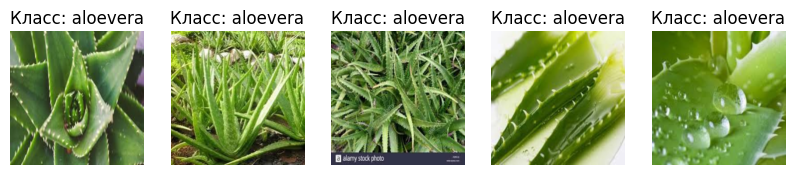

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Взять 1 батч данных
images, labels = next(iter(test_loader))

# Визуализация нескольких изображений
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Перекладываем каналы
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Де-нормализация
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Класс: {test_dataset.classes[labels[i]]}")

plt.show()

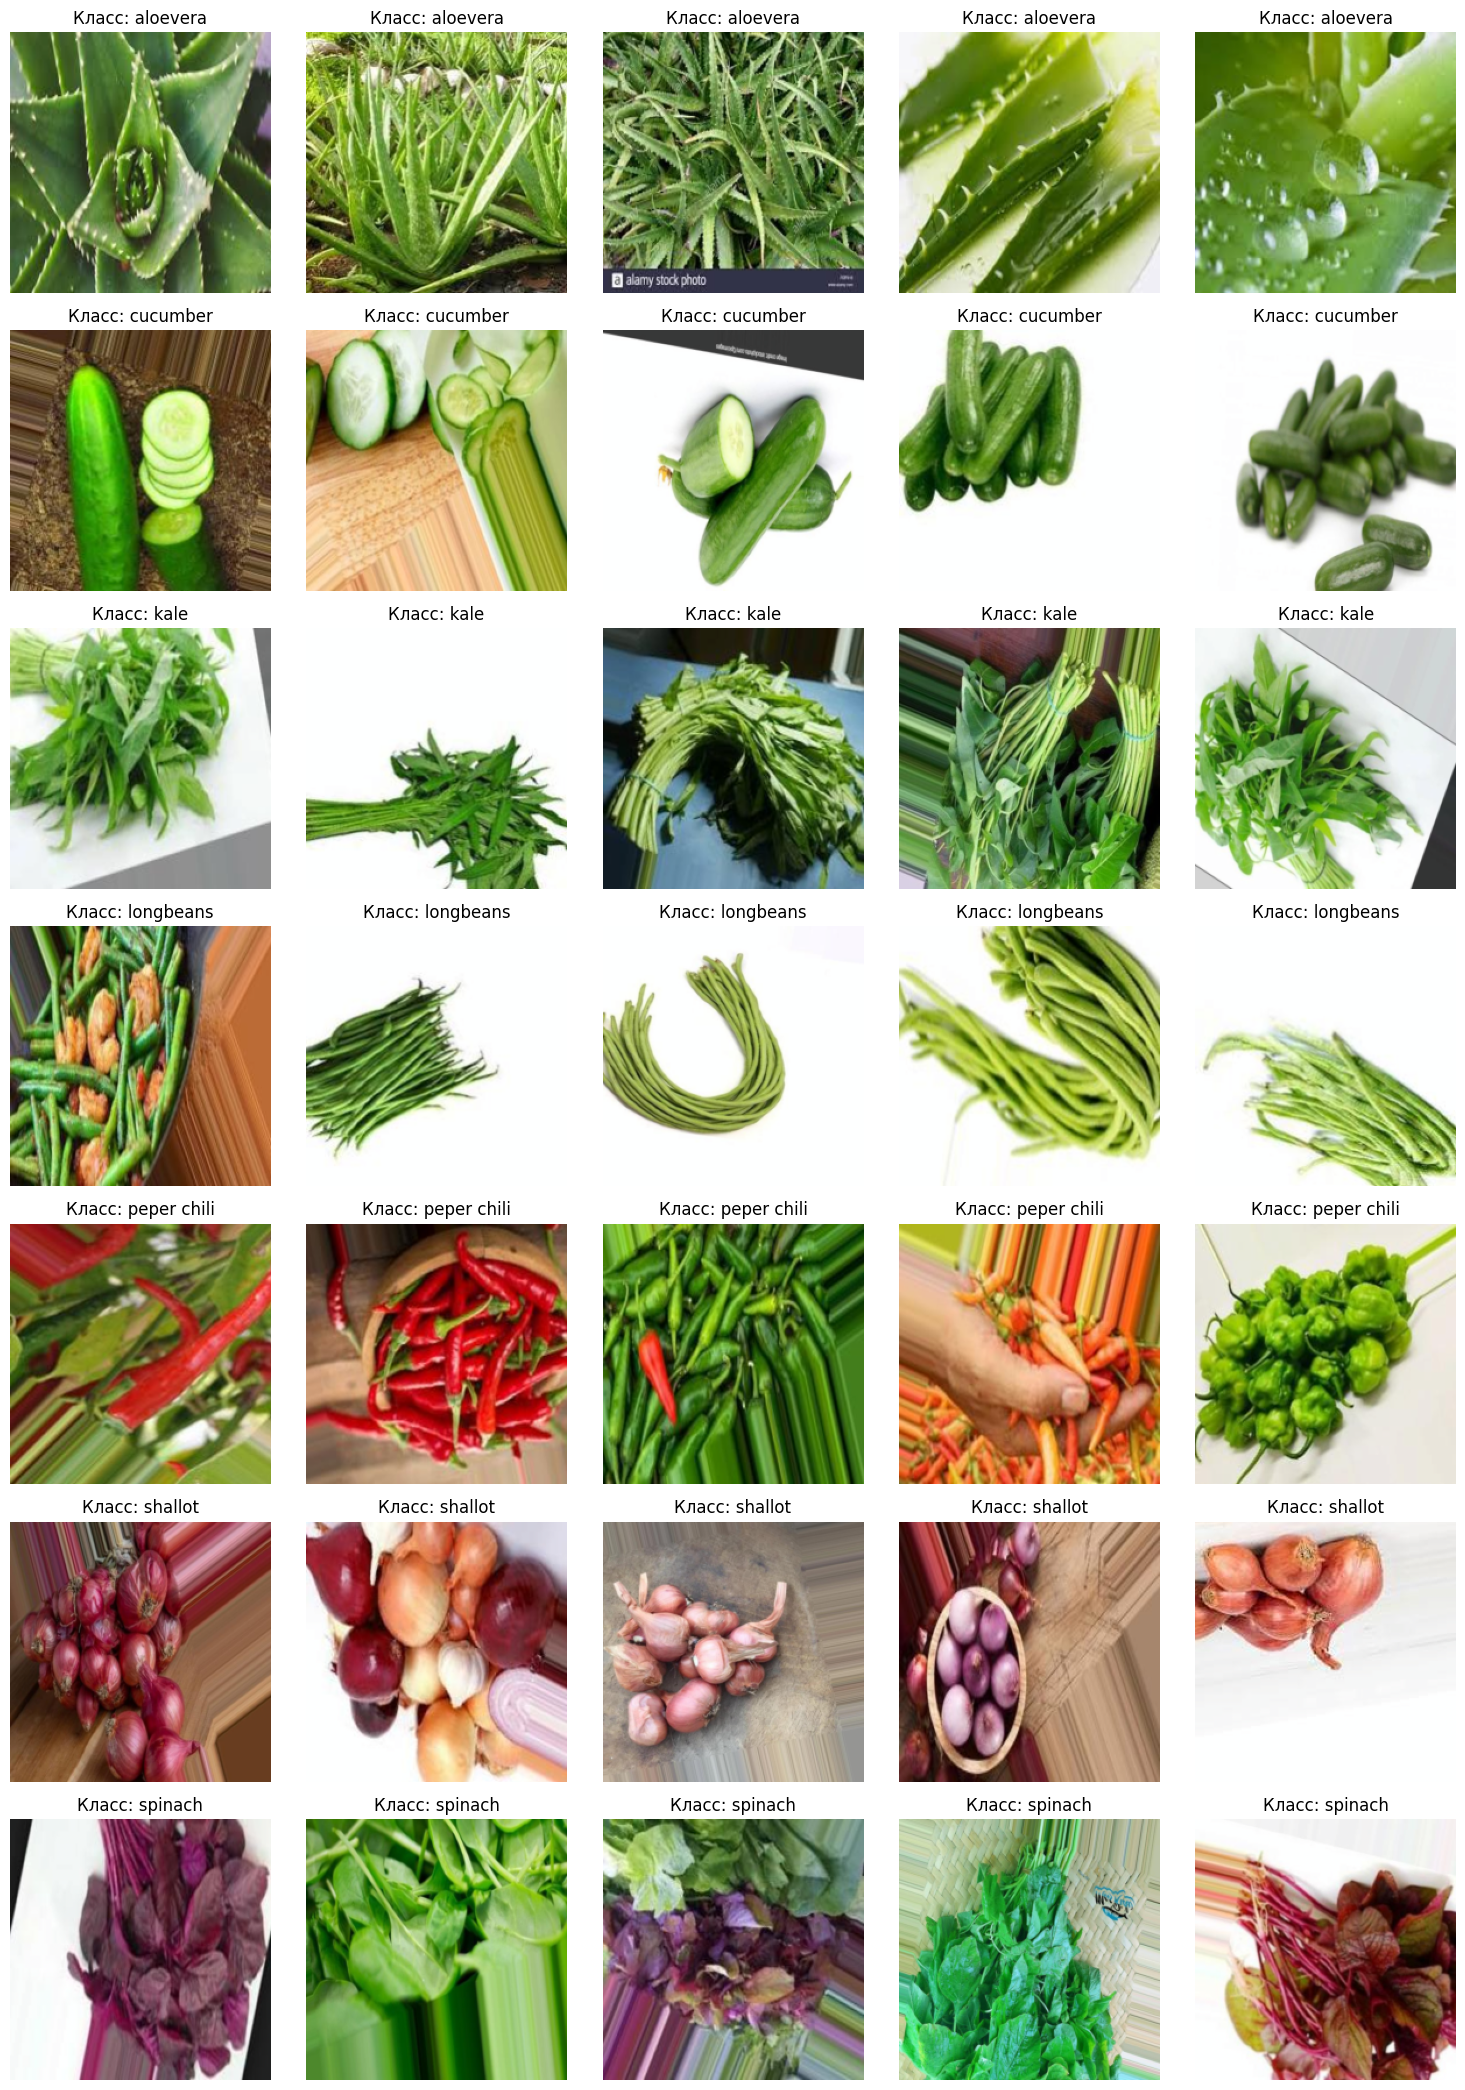

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для визуализации изображений всех классов
def visualize_all_classes(test_loader, test_dataset, num_classes=5):
    # Перебор всех классов и создание подграфиков для каждого
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, 3 * num_classes))
    
    # Для каждого класса
    for class_idx in range(num_classes):
        # Получаем изображения и метки для данного класса
        class_images, class_labels = [], []
        for images, labels in test_loader:
            for i in range(len(labels)):
                if labels[i] == class_idx:  # Проверяем, соответствует ли метка классу
                    class_images.append(images[i])
                    class_labels.append(labels[i])

        # Визуализация картинок для данного класса
        for i in range(min(5, len(class_images))):  # Ограничиваем до 5 изображений на класс
            img = class_images[i].permute(1, 2, 0).numpy()  # Перекладываем каналы
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Де-нормализация
            img = np.clip(img, 0, 1)

            ax = axes[class_idx, i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Класс: {test_dataset.classes[class_idx]}")

    plt.tight_layout()
    plt.show()

# Пример вызова функции
visualize_all_classes(test_loader, test_dataset, num_classes=len(test_dataset.classes))


In [37]:
import torch
from sklearn.metrics import accuracy_score

# Переключаем модель в режим оценки
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Берём индекс класса с наибольшей вероятностью
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Оцениваем точность
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Точность на тестовых данных: {accuracy:.4f}")


Точность на тестовых данных: 0.7482


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), "mobilenetv2_model.pth")  # Сохраняем только веса


In [ ]:
# Загружаем модель (с той же архитектурой, которую использовали при обучении)
model = timm.create_model("mobilenetv2_100", pretrained=False, num_classes=7)

# Загружаем сохраненные веса в модель
model.load_state_dict(torch.load("mobilenetv2_model.pth"))  # Убедитесь, что путь указан правильно

# Переводим модель на нужное устройство (GPU или CPU)
model = model.to(device)

# Переводим модель в режим оценки (для предсказаний)
model.eval()